In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/birdclef-2023/sample_submission.csv
/kaggle/input/birdclef-2023/eBird_Taxonomy_v2021.csv
/kaggle/input/birdclef-2023/train_metadata.csv
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC247367.ogg
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC574558.ogg
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC403259.ogg
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC498854.ogg
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC289493.ogg
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC716763.ogg
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC498853.ogg
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC338717.ogg
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC349660.ogg
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC403543.ogg
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC574557.ogg
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC346069.ogg
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC530126.ogg
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC530241.

In [79]:
# importing the Nessesecry Library
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

import pandas as pd
import numpy as np
import librosa
import glob
import matplotlib.pyplot as plt

import csv
import io

from IPython.display import Audio

In [8]:
i,j=librosa.load('/kaggle/input/birdclef-2023/train_audio/yetgre1/XC530241.ogg')
Audio(data=i,rate=j)

In [9]:
i,j=librosa.load('/kaggle/input/birdclef-2023/train_audio/edcsun3/XC434334.ogg')
Audio(data=i,rate=j)

Now Loading the Model from Google


In [19]:
import tensorflow_hub as hub
        
keras_layer = hub.load('https://kaggle.com/models/google/bird-vocalization-classifier/frameworks/TensorFlow2/variations/bird-vocalization-classifier/versions/1')


In [20]:
labels_path = hub.resolve('https://kaggle.com/models/google/bird-vocalization-classifier/frameworks/tensorFlow2/variations/bird-vocalization-classifier/versions/1') + "/assets/label.csv"

In [21]:
print(labels_path)

/kaggle/input/bird-vocalization-classifier/tensorflow2/bird-vocalization-classifier/1/assets/label.csv


In [22]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    with open(labels_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        class_names = [mid for mid, desc in csv_reader]
        return class_names[1:]

## note that the bird classifier classifies a much larger set of birds than the
## competition, so we need to load the model's set of class names or else our 
## indices will be off.
classes = class_names_from_csv(labels_path)

In [34]:
print("this is the classes that are available in the Pretrained Model of Google Bird Classifier:",len(set(classes)))

this is the classes that are available in the Pretrained Model of Google Bird Classifier: 10932


In [39]:
train_metadata = pd.read_csv("/kaggle/input/birdclef-2023/train_metadata.csv")
train_metadata.head(10)
traning_classes=sorted(train_metadata.primary_label.unique())
print(traning_classes[:5])
print(len(set(traning_classes)))

['abethr1', 'abhori1', 'abythr1', 'afbfly1', 'afdfly1']
264


In [44]:
count=0
list1=[]
for i in  traning_classes: 
    try:
        c=classes.index(i)
        list1.append(c)
    except:
        list1.append(0)
        count+=1
        print(i)
print("This are the number of classes which are not present in the Pre defined Traning model: ",count)

fotdro5
quailf1
sacibi2
This are the number of classes which are not present in the Pre defined Traning model:  3


In [59]:
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 5.0,
      hop_size_s: float = 5.0,
      sample_rate = 32000,
      ) -> np.ndarray:
    
    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

In [51]:
def ensure_sample_rate(waveform, original_sample_rate,
                       desired_sample_rate=32000):
    """Resample waveform if required."""
    if original_sample_rate != desired_sample_rate:
        waveform = tfio.audio.resample(waveform, original_sample_rate, desired_sample_rate)
    return waveform,desired_sample_rate

In [55]:
audio,sample_rate=librosa.load('/kaggle/input/birdclef-2023/train_audio/blcapa2/XC120193.ogg')
print(sample_rate)
before_sample=Audio(data=audio,rate=sample_rate)
audio,sample_rate=ensure_sample_rate(audio,sample_rate)
print(sample_rate)
after_sample=Audio(data=audio,rate=sample_rate)


22050
32000


In [56]:
# this is the audio before sampeling
before_sample

In [57]:
#this is the Audio after sampleing
after_sample

In [61]:
fixed_audio=frame_audio(audio)

In [62]:
print(fixed_audio)

tf.Tensor(
[[-2.7847646e-11  2.0203031e-10 -4.2933340e-10 ... -7.4112962e-04
  -1.9367405e-03 -1.9462861e-03]
 [-1.5017469e-03 -9.0191059e-04  1.6536871e-04 ... -2.9551643e-03
  -2.7111406e-03 -2.8484943e-03]
 [-4.8192474e-03 -5.7432251e-03 -3.1102886e-03 ... -3.1342404e-03
  -1.5705263e-03  1.6608101e-07]
 ...
 [-6.9740904e-03 -3.9757341e-03 -1.4570922e-03 ...  3.2500885e-03
   3.7261480e-03  3.7373700e-03]
 [ 3.4860352e-03  2.8930996e-03  2.6081149e-03 ...  2.1178552e-03
   2.9583732e-03  2.6780632e-03]
 [ 1.4917139e-03 -2.5054195e-04 -1.9478556e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]], shape=(8, 160000), dtype=float32)


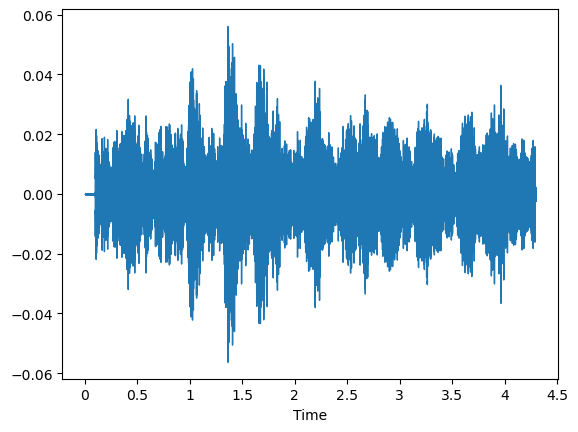

In [76]:
librosa.display.waveshow(np.array(librosa.load('/kaggle/input/birdclef-2023/train_audio/yetgre1/XC530241.ogg')[0]))

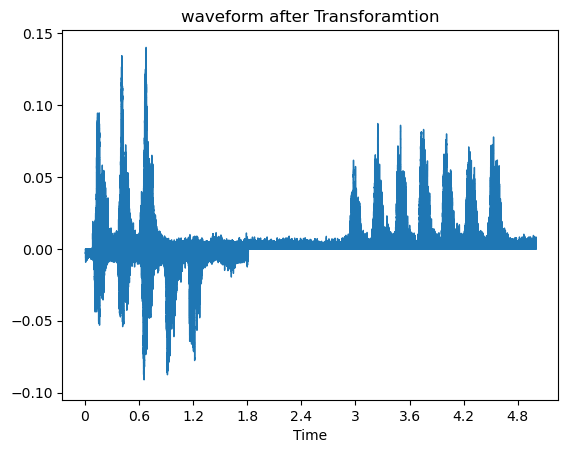

In [82]:
librosa.display.waveshow(np.array(fixed_audio),sr=sample_rate)
plt.title('waveform after Transforamtion')
plt.show()

In [91]:
logits,_ = keras_layer.infer_tf(fixed_audio[:1])

In [92]:
print(logits)
print(logits.shape)
print(np.argmax(logits))

tf.Tensor([[-13.050788 -12.427911 -12.696111 ... -15.30043  -14.820935 -11.022415]], shape=(1, 10932), dtype=float32)
(1, 10932)
1150


In [104]:
classes[np.argmax(tf.nn.softmax(logits))],tf.nn.softmax(logits)[0][np.argmax(tf.nn.softmax(logits))]

('blcapa2', <tf.Tensor: shape=(), dtype=float32, numpy=0.9854396>)

In [113]:
classes[1150]

'blcapa2'

In [133]:
def predict_audio(filename, sample_submission, frame_limit_secs=None):
    file_id = filename.split(".ogg")[0].split("/")[-1]
    audio, sample_rate = librosa.load(filename)
    wav_data,sample_rate, = ensure_sample_rate(audio, sample_rate)
    fixed_audio = frame_audio(wav_data)
    frame = 5
    all_logits, all_embeddings = keras_layer.infer_tf(fixed_audio[:1])
    for window in fixed_audio[1:]:
        if frame_limit_secs and frame > frame_limit_secs:
            continue
        
        logits, embeddings = keras_layer.infer_tf(window[np.newaxis, :])
        all_logits = np.concatenate([all_logits, logits], axis=0)
        frame += 5
        frame = 5
    all_probabilities = []
    for frame_logits in all_logits:
        probabilities = tf.nn.softmax(frame_logits).numpy()
        
        ## set the appropriate row in the sample submission
        sample_submission.loc[sample_submission.row_id == file_id + "_" + str(frame),traning_classes] = probabilities[list1]
        frame += 5

In [121]:
test_samples = list(glob.glob("/kaggle/input/birdclef-2023/test_soundscapes/*.ogg"))
test_samples


['/kaggle/input/birdclef-2023/test_soundscapes/soundscape_29201.ogg']

In [123]:
sample_sub = pd.read_csv("/kaggle/input/birdclef-2023/sample_submission.csv")
sample_sub[traning_classes] = sample_sub[traning_classes].astype(np.float32)
sample_sub.head()

row_id  abethr1  abhori1  abythr1  afbfly1  afdfly1  afecuc1  \
0   soundscape_29201_5      0.0      0.0      0.0      0.0      0.0      0.0   
1  soundscape_29201_10      0.0      0.0      0.0      0.0      0.0      0.0   
2  soundscape_29201_15      0.0      0.0      0.0      0.0      0.0      0.0   

   affeag1  afgfly1  afghor1  ...  yebsto1  yeccan1  yefcan  yelbis1  yenspu1  \
0      0.0      0.0      0.0  ...      0.0      0.0     0.0      0.0      0.0   
1      0.0      0.0      0.0  ...      0.0      0.0     0.0      0.0      0.0   
2      0.0      0.0      0.0  ...      0.0      0.0     0.0      0.0      0.0   

   yertin1  yesbar1  yespet1  yetgre1  yewgre1  
0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0  

[3 rows x 265 columns]

In [126]:
sample_sub.shape[0]

3

In [134]:
frame_limit_secs = 15 if sample_sub.shape[0] == 3 else None
for sample_filename in test_samples:
    predict_audio(sample_filename, sample_sub, frame_limit_secs=15)

In [135]:
sample_sub

row_id   abethr1   abhori1   abythr1   afbfly1   afdfly1  \
0   soundscape_29201_5  0.000003  0.000006  0.000065  0.000002  0.000002   
1  soundscape_29201_10  0.000011  0.000299  0.000012  0.000332  0.000013   
2  soundscape_29201_15  0.000220  0.000744  0.000434  0.000048  0.000005   

    afecuc1   affeag1       afgfly1   afghor1  ...       yebsto1   yeccan1  \
0  0.000025  0.000001  5.692969e-07  0.000053  ...  1.850722e-07  0.000003   
1  0.000013  0.000032  1.564853e-06  0.000003  ...  1.845698e-06  0.000069   
2  0.000090  0.000002  2.211967e-05  0.000005  ...  2.365065e-06  0.000027   

     yefcan       yelbis1       yenspu1   yertin1   yesbar1   yespet1  \
0  0.000003  1.290750e-07  1.641811e-07  0.000001  0.000002  0.000001   
1  0.000080  5.035347e-04  1.903989e-06  0.000032  0.000012  0.000142   
2  0.000322  4.070568e-05  1.545971e-05  0.000019  0.000002  0.005072   

        yetgre1   yewgre1  
0  5.424437e-07  0.000001  
1  4.474470e-06  0.000264  
2  3.049723e-05  0.000053  

[3 rows x 265 columns]

In [136]:
sample_sub.to_csv("submission.csv", index=False)